In [50]:
suppressMessages({
    library(RNetCDF)
    library(dplyr)
    library(tidyr)
    library(ggplot2)
    library(maptools)
    # library(mapview)
    library(sf)
    # library(leaflet)
    library(sfheaders)
    # library(raster)
    library(fuzzyjoin)
    # library(survival)
    library(parallel)
    # library(patchwork)
})


In [47]:
source('/work/a06/yingying/SWOT/jupyter/make_raster_df.R')
source('/work/a06/yingying/SWOT/jupyter/create_gauge_df.R')

In [3]:
raster_path='/work/a06/yingying/SWOT/raster/100/'
raster_files=list.files(raster_path,full.names=TRUE)
gauge_base_path='/work/a06/yingying/obs/'

In [42]:
gauge_metadata<-read.csv('/work/a06/yingying/SWOT/gauge/MLIT_FlowGauge_all_info.csv')
gauge_metadata<- gauge_metadata %>%
    filter(Lat < 179 & Lat > 1)
gauge_metadata<- gauge_metadata %>%
    filter(Lon < 359 & Lon > 1)
gauge_ID <- as.character(gauge_metadata$ID)
datum  <- gauge_metadata$New_elv
lat    <- gauge_metadata$Lat
lon    <- gauge_metadata$Lon
gauge_metadata_sf <- st_as_sf(gauge_metadata, coords = c('Lon', 'Lat'))

Simple feature collection with 2069 features and 2 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 127.914 ymin: 26.454 xmax: 145.125 ymax: 45.403
CRS:           NA
First 10 features:
             ID New_elv               geometry
1  1.042110e+12   12.17 POINT (141.927 44.895)
2  1.042110e+12  999.00 POINT (141.502 42.849)
3  1.042111e+12    0.00 POINT (142.217 42.782)
4  1.042111e+12    0.00 POINT (142.146 42.772)
5  1.042111e+12    0.00 POINT (142.301 42.723)
6  1.042111e+12    0.00 POINT (142.184 42.672)
7  1.042111e+12    0.00 POINT (144.298 43.054)
8  1.042111e+12    0.00 POINT (144.452 43.041)
9  1.042129e+12  999.00  POINT (141.85 45.403)
10 1.362120e+12  203.44 POINT (140.423 37.932)


In [ ]:
npix_filter=1
qual_bitwise_filter=3200000000
water_frac_filter=0.1

a=Sys.time()

  clust <- makeCluster(23)



swot_gauge_match=do.call(rbind,parLapply(clust,raster_files,make_raster_df,
                                      gauge_metadata_sf=gauge_metadata_sf,
                                      npix_filter=npix_filter,
                                      qual_bitwise_filter=qual_bitwise_filter,
                                      water_frac_filter=water_frac_filter))


stopCluster(clust)

b= Sys.time()
print(b-a)

In [48]:
#filter for which gauges actually exist
gauge_files1=list.files('/work/a06/yingying/SWOT/gauge/2023/',full.names=TRUE)
gauge_files2=list.files('/nas/cee-water/cjgleason/colin/analyze confluence runs/wlv/2024/',full.names=TRUE)

swot_2023=filter(swot_gauge_match,SWOT_time < '2024-01-01')

gauges_in_files1=lapply(swot_2023$gauge_ID , grep, gauge_files1) 
swot_gauge_match_hasdata1=swot_2023[which(lengths(gauges_in_files1)!=0),]

swot_2024=filter(swot_gauge_match, SWOT_time > '2023-12-31')

gauges_in_files2=lapply(swot_2024$gauge_ID , grep, gauge_files2) 
swot_gauge_match_hasdata2=swot_2024[which(lengths(gauges_in_files2)!=0),]

swot_gauge_match_hasdata=rbind(swot_gauge_match_hasdata1,swot_gauge_match_hasdata2)

In [49]:
# plot(swot_gauge_match_hasdata$SWOT_time)
# head(swot_gauge_match_hasdata)

In [50]:
# source('/nas/cee-water/cjgleason/colin/analyze confluence runs/make_raster_df.R')
# source('/nas/cee-water/cjgleason/colin/analyze confluence runs/create_gauge_df.R')

# test=create_gauge_df(swot_gauge_match_hasdata$gauge_ID[80],
#                      gauge_base_path=gauge_base_path,
#                      swot_gauge_match_hasdata=swot_gauge_match_hasdata,
#                       join_tolerance_sec=1800)

# # as.POSIXct(test$gauge_time)

#  # nrow(test)
#  # head(test)


In [55]:
  clust <- makeCluster(23)
source('/nas/cee-water/cjgleason/colin/analyze confluence runs/make_raster_df.R')
source('/nas/cee-water/cjgleason/colin/analyze confluence runs/create_gauge_df.R')

combined_df=parLapply(clust,as.list(swot_gauge_match_hasdata$gauge_ID),
                     create_gauge_df,
                     gauge_base_path=gauge_base_path,
                     swot_gauge_match_hasdata=swot_gauge_match_hasdata,
                    join_tolerance_sec=3600)


stopCluster(clust)



In [99]:

combined_df1=do.call(rbind,lapply(list.files('/nas/cee-water/cjgleason/colin/analyze confluence runs/raster_outputs/',full.names=TRUE),
                     readRDS))%>%

    mutate(gauge_wse=gauge_height+datum)%>%
    distinct()%>%
    ungroup()%>%
    mutate(wse_diff= gauge_wse-wse)%>%
    mutate(latitude=latitude.x)%>%
    mutate(longitude=longitude.x)

summarizer=combined_df1%>%
    group_by(gauge_ID.y)%>%
    summarize(meanSWOT =  median(wse), meanGauge= median(gauge_wse))

combined_df= dplyr::select(combined_df1, gauge_wse,wse,wse_diff,timediff, gauge_ID.y, latitude, longitude,gauge_to_swot_km,
               water_area_uncert,wse_qual_bitwise,sig0_qual_bitwise,water_area_qual_bitwise,cross_track,n_wse_pix,water_frac) %>%
    left_join(summarizer,by='gauge_ID.y')%>%
    mutate(relSWOT= wse - meanSWOT)%>%
    mutate(relGauge= gauge_wse -meanGauge)%>%
    mutate(relDiff= relGauge-relSWOT)

In [101]:
head(summarizer)

gauge_ID.y,meanSWOT,meanGauge
<chr>,<dbl>,<dbl>
1362130351240,13.498515,4.6200
1362130351480,1.285885,0.5148
1362130375040,303.049438,291.8056
1362130376010,988.062439,986.6588
1362130376020,1103.803223,1000.1000
1362130376050,692.277649,623.7200


In [102]:
# swot_gauge_match_hasdata$SWOT_time
nrow(combined_df)
length(unique(combined_df$gauge_ID.y))
print(paste('RMSE = ', round(sqrt(mean(combined_df$wse_diff^2)),digits=2), 'm'))
print(paste('RMSE rel WSE  = ', round(sqrt(mean(combined_df$relDiff^2)),digits=2), 'm'))
names(combined_df)



[1] 24146

[1] 446

[1] "RMSE =  66.21 m"
[1] "RMSE rel WSE  =  31.38 m"


[1] "gauge_wse"               "wse"                    
 [3] "wse_diff"                "timediff"               
 [5] "gauge_ID.y"              "latitude"               
 [7] "longitude"               "gauge_to_swot_km"       
 [9] "water_area_uncert"       "wse_qual_bitwise"       
[11] "sig0_qual_bitwise"       "water_area_qual_bitwise"
[13] "cross_track"             "n_wse_pix"              
[15] "water_frac"              "meanSWOT"               
[17] "meanGauge"               "relSWOT"                
[19] "relGauge"                "relDiff"

In [154]:
plotter_sig0=combined_df%>%
 filter(sig0_qual_bitwise ==2 | sig0_qual_bitwise ==4 |  sig0_qual_bitwise ==6 )
goodsig=nrow(plotter_sig0)

plotter_wse=combined_df%>%
 filter(wse_qual_bitwise ==2 | wse_qual_bitwise ==4 |  wse_qual_bitwise ==6 )
goodwse=nrow(plotter_wse)

plotter_area=combined_df%>%
 filter(water_area_qual_bitwise ==2 | water_area_qual_bitwise ==4 |  water_area_qual_bitwise ==6 )
goodarea=nrow(plotter_area)
nrow(plotter_area)

[1] 2730

In [171]:
p1=ggplot(plotter_area)+
    # geom_point(aes(x=relGauge,y=relSWOT,col=as.factor(water_area_qual_bitwise)))+
    # geom_line(aes(x=relGauge,y=relGauge))+
    geom_point(aes(x=wse,y=gauge_wse,col=as.factor(water_area_qual_bitwise)))+
    geom_line(aes(x=gauge_wse,y=gauge_wse))+
     coord_cartesian(xlim=c(0,50),ylim=c(0,50))+
    ylab('gauge height(m)')+
     xlab("swot height(m)")+
    # xlim(c(-95,99))+
    labs(color='water area qual ') +
    theme_bw() +
ggtitle(paste('n= ',goodarea))+
      theme(legend.text=element_text(size=16),
        # legend.title=element_text('water area quality bitwise'),
            
        #legend.position =c(0.8,0.8),
        axis.text.y= element_text(size=16),
        #legend.position = 'none',
         axis.text.x =element_text(size=16),
        #axis.text.x=element_blank(),
        axis.title.x= element_text(size=14),
        axis.title.y= element_text(size=12),
        #panel.grid.major = element_line(colour = "grey50"),
        plot.title = element_text(color="black", size=16, face="bold.italic"))
       # legend.background = element_rect(fill=alpha('white',0.8)))
    # axis.text.x = element_text(angle =45, vjust = 1, hjust=1)) 

p2=ggplot(plotter_sig0)+
   # geom_point(aes(x=relGauge,y=relSWOT,col=as.factor(sig0_qual_bitwise)))+
   #  geom_line(aes(x=relGauge,y=relGauge))+
  geom_point(aes(x=wse,y=gauge_wse,col=as.factor(sig0_qual_bitwise)))+
    geom_line(aes(x=gauge_wse,y=gauge_wse))+
     coord_cartesian(xlim=c(0,50),ylim=c(0,50))+
    ylab('gauge height(m)')+
     xlab("swot height(m)")+
    # xlim(c(-95,99))+
    labs(color='sig0 qual') +
    theme_bw() +
ggtitle(paste('n= ',goodsig))+
      theme(legend.text=element_text(size=16),
        # legend.title=element_text('water area quality bitwise'),
            
        #legend.position =c(0.8,0.8),
        axis.text.y= element_text(size=16),
        #legend.position = 'none',
         axis.text.x =element_text(size=16),
        #axis.text.x=element_blank(),
        axis.title.x= element_text(size=14),
        axis.title.y= element_text(size=12),
        #panel.grid.major = element_line(colour = "grey50"),
        plot.title = element_text(color="black", size=16, face="bold.italic"))
       # legend.background = element_rect(fill=alpha('white',0.8)))
    # axis.text.x = element_text(angle =45, vjust = 1, hjust=1)) 

p3=ggplot(plotter_wse)+
   # geom_point(aes(x=relGauge,y=relSWOT,col=as.factor(wse_area_qual_bitwise)))+
   #  geom_line(aes(x=relGauge,y=relGauge))+
geom_point(aes(x=wse,y=gauge_wse,col=as.factor(wse_qual_bitwise)))+
    geom_line(aes(x=gauge_wse,y=gauge_wse))+
     coord_cartesian(xlim=c(0,50),ylim=c(0,50))+
    ylab('gauge height(m)')+
     xlab("swot height(m)")+
    # xlim(c(-95,99))+
    labs(color='wse qual') +
    theme_bw() +
ggtitle(paste('n= ',goodwse))+
      theme(legend.text=element_text(size=16),
        # legend.title=element_text('water area quality bitwise'),
            
        #legend.position =c(0.8,0.8),
        axis.text.y= element_text(size=16),
        #legend.position = 'none',
         axis.text.x =element_text(size=16),
        #axis.text.x=element_blank(),
        axis.title.x= element_text(size=14),
        axis.title.y= element_text(size=12),
        #panel.grid.major = element_line(colour = "grey50"),
        plot.title = element_text(color="black", size=16, face="bold.italic"))
       # legend.background = element_rect(fill=alpha('white',0.8)))
    # axis.text.x = element_text(angle =45, vjust = 1, hjust=1)) 

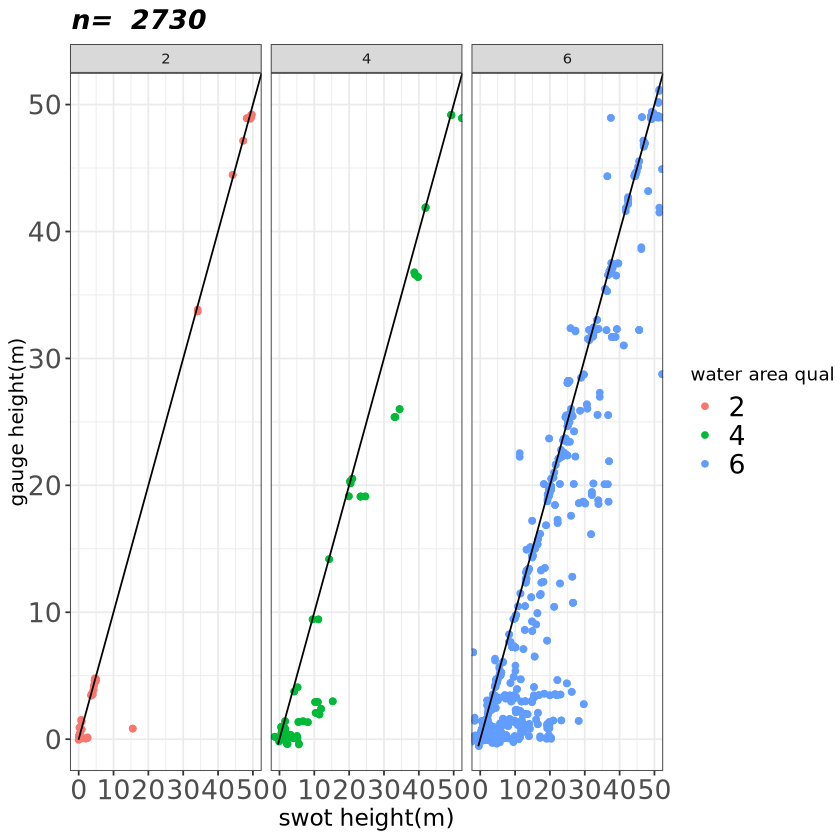

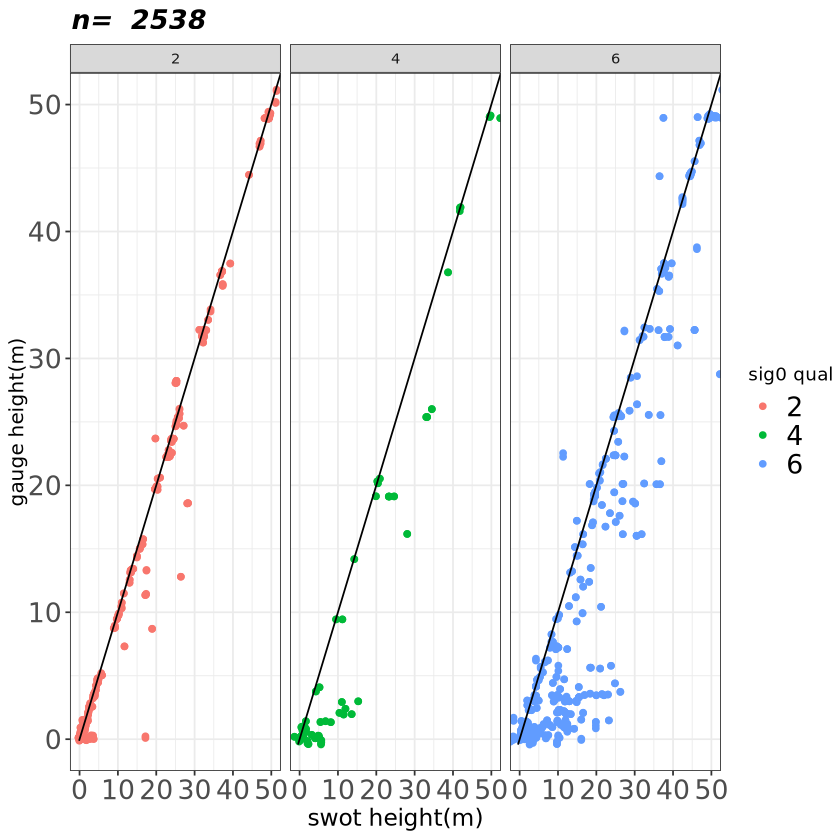

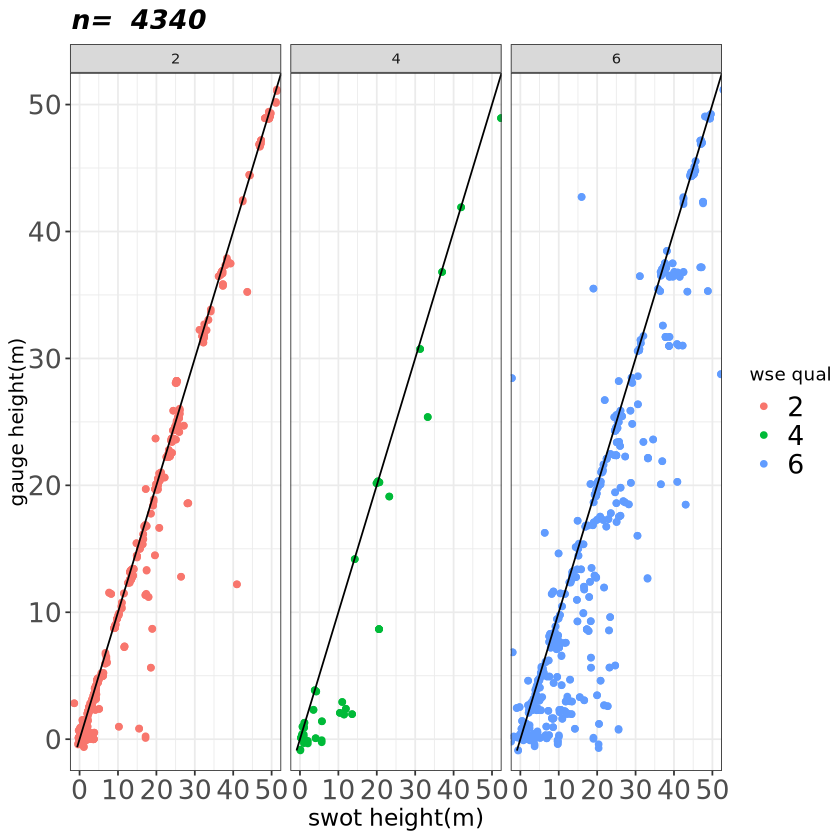

In [173]:
p1+ facet_wrap(vars(water_area_qual_bitwise))
 p2+ facet_wrap(vars(sig0_qual_bitwise))
p3+ facet_wrap(vars(wse_qual_bitwise))

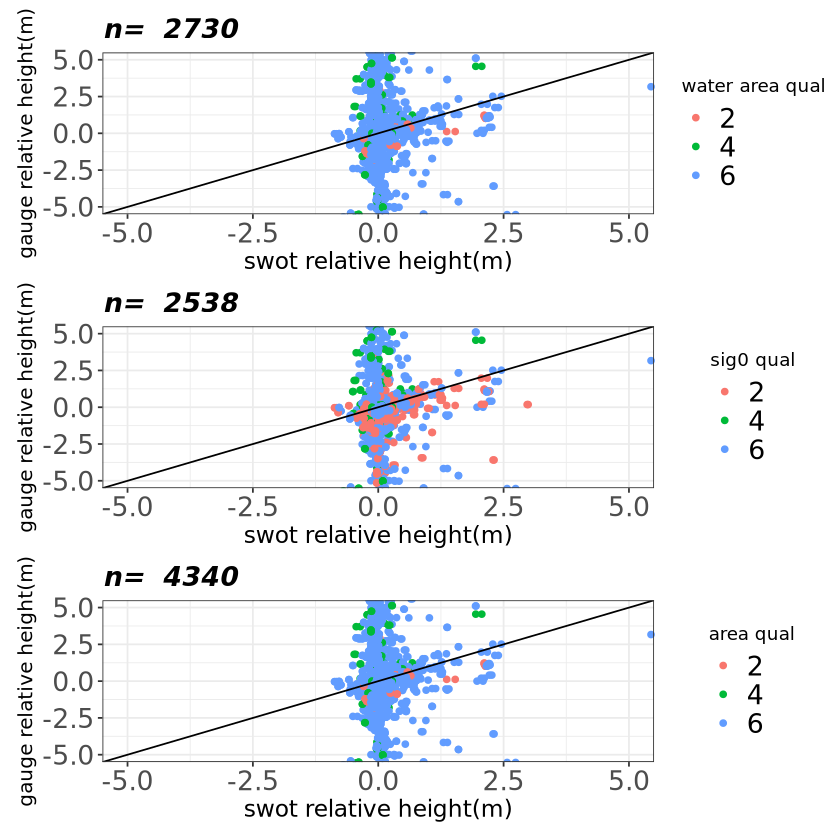

In [158]:
p1 + p2 + p3 + plot_layout(ncol=1)

In [ ]:
conpal <- colorBin(palette = "viridis",
                   domain=combined_df$wse_diff, 
                   # bins=round(quantile(allSword2$consensus_mean_Q,  na.rm=TRUE, probs=seq(0, 1, 0.18))),
                   na.color=NA,
                   reverse=TRUE)

leaflet(combined_df, options=leafletOptions(zoomControl=FALSE, minZoom=1.5), height = 600) %>%
        addProviderTiles(providers$CartoDB.Positron)%>%
         addCircleMarkers(
                   color = ~conpal(wse_diff),
                   weight = 1,
                    label = ~wse_diff,
                   opacity=2)%>%
        addLegend(pal=conpal, 
                  values = ~wse_diff,
                 title = 'SWOT vs gauge difference' )